In [1]:
from torch_geometric.explain import Explainer, AttentionExplainer, GNNExplainer, unfaithfulness

from genericpath import exists

from cell_model import Gatv2Predictor

import torch

import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from cell_dataset import RealCellGraphDataset, cross_val_real

In [2]:
load_all =  True #load directly from a pickle
pre_separated = False #if three subfolders already exist for train test and val

override = False #make this true to always use the same ones

aggr = "mean"

number_of_messages = 2
size_of_messages = 128
epochs = 0
distrib = "normal"
horizon = 4

leave_out = 0

name_complete = "_" + str(number_of_messages) + "_" + str(size_of_messages) + "_" + distrib + "_h" + str(horizon) + "_leave" + str(leave_out)

path_name = "models/real/" + distrib + "/h" + str(horizon) + "/"

model_path = path_name + "model" + name_complete

data_train, data_test = cross_val_real("data/cell_data/cell_data/", leave_out=leave_out)

Found paths:  ['/mnt/c/Users/gille/Desktop/graph-displacement/data/cell_data/cell_data/tracks_12.h5', '/mnt/c/Users/gille/Desktop/graph-displacement/data/cell_data/cell_data/tracks_18.h5', '/mnt/c/Users/gille/Desktop/graph-displacement/data/cell_data/cell_data/tracks_72.h5', '/mnt/c/Users/gille/Desktop/graph-displacement/data/cell_data/cell_data/tracks_25.h5']
Leaving out:  /mnt/c/Users/gille/Desktop/graph-displacement/data/cell_data/cell_data/tracks_12.h5
Length:  4


In [3]:
model = Gatv2Predictor(in_channels=8+1+1, out_channels=16, hidden_channels=size_of_messages, dropout=0.05, edge_dim=2, messages=number_of_messages, wrap=data_train.wrap, horizon=horizon)
    
#Load model  

epoch_to_load = 1600
if exists(model_path + str(epoch_to_load) + ".pt") :
    model.load_state_dict(torch.load(model_path + str(epoch_to_load) + ".pt"))
    print("Loaded model")
    

Loaded model


In [10]:
def iterate(data, x, params, masks, model, duration, device, draw, distrib, many_many, explainer):
    out = x[0].detach().clone().unsqueeze(dim=0).to(device)

    _, edge_index, edge_attr = data.get_edges(out[0,:,:2], data.max_degree, wrap=data.wrap, masks=masks[0])
    
    horizon = model.horizon
    
    gs = []
    widthss = []
        
    for current_time in range(0, duration-1) :
        #time embedding
        recent = out[-horizon:].detach().clone().to(device)
        
        time = torch.arange(1, recent.shape[0] + 1, device=device).unsqueeze(1).unsqueeze(2).repeat(1, recent.shape[1], 1).float() / (recent.shape[0] + 1)
        
        input_model = torch.cat((recent, time), dim=2)
        
        output = model(input_model, edge_index.to(device), edge_attr.to(device), params, many_many=many_many)
        
        if draw : 
            values = model.draw(output, distrib=distrib).to(device) + out[current_time,:,:model.out_channels//2]
        else :
            values = output[:,:,:model.out_channels//2] + out[current_time,:,:model.out_channels//2]
            
        explanation = explainer(x=input_model[-1], edge_index=edge_index, edge_attr=edge_attr)
        assert(explanation.validate() == True)
        exp = explanation.get_explanation_subgraph()
        g = torch_geometric.utils.to_networkx(exp, to_undirected=False, remove_self_loops=True)
        widths = explanation.edge_mask.cpu().numpy()
        
        gs.append(g)
        widthss.append(widths)
        
        returned, edge_index, edge_attr = data.get_edges(values[:,:,:2], data.max_degree, wrap=data.wrap, previous=out[current_time,:,:2], masks=None)
        
        if values.shape[0] > 1 and values.shape[0] < duration - 1:
            #very slow thing 
            _, edge_index, edge_attr = data.get_edges(values[-1,:,:2], data.max_degree, wrap=data.wrap, previous=None, masks=None)
                
        if model.out_channels == 4 :
            values = returned
        else :
            #add back the degree of the node
            values = torch.cat((values, returned[:,:,-1].unsqueeze(2)), dim=2)
        
        out = torch.cat((out, values), dim=0)
          
    return gs, out[1:duration,:,:2].detach(), widthss

In [11]:
def explainer_explain(title, explainer, model) :
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    explainer.algorithm = explainer.algorithm.to(device)

    duration, x, edge_index, edge_attr, masks = data_test.get(0, duration=-1)
    
    gs, outs, widths = iterate(data_test, x, None, masks, model, duration, device, True, distrib, False, explainer)

    figure = plt.figure(figsize=(10, 10))

    def animationFunction(i):
        #clear the figure
        plt.clf()
        
        print("Frame " + str(i) + "/" + str(duration) + " (" + str(i/duration*100) + "%)")

        nx.draw(G=gs[i], with_labels=True, width=widths[i])
        
        return figure,

    anim = FuncAnimation(figure, animationFunction, frames=duration-1, interval=100, blit=True)

    anim.save(title + "_animation" + name_complete + ".gif", writer="ffmpeg")

Frame 0/48 (0.0%)
Frame 0/48 (0.0%)
Frame 0/48 (0.0%)
Frame 0/48 (0.0%)
Frame 1/48 (2.083333333333333%)
Frame 2/48 (4.166666666666666%)
Frame 3/48 (6.25%)
Frame 4/48 (8.333333333333332%)
Frame 5/48 (10.416666666666668%)
Frame 6/48 (12.5%)
Frame 7/48 (14.583333333333334%)
Frame 8/48 (16.666666666666664%)
Frame 9/48 (18.75%)
Frame 10/48 (20.833333333333336%)
Frame 11/48 (22.916666666666664%)
Frame 12/48 (25.0%)
Frame 13/48 (27.083333333333332%)
Frame 14/48 (29.166666666666668%)
Frame 15/48 (31.25%)
Frame 16/48 (33.33333333333333%)
Frame 17/48 (35.41666666666667%)
Frame 18/48 (37.5%)
Frame 19/48 (39.58333333333333%)
Frame 20/48 (41.66666666666667%)
Frame 21/48 (43.75%)
Frame 22/48 (45.83333333333333%)
Frame 23/48 (47.91666666666667%)
Frame 24/48 (50.0%)
Frame 25/48 (52.083333333333336%)
Frame 26/48 (54.166666666666664%)
Frame 27/48 (56.25%)
Frame 28/48 (58.333333333333336%)
Frame 29/48 (60.416666666666664%)
Frame 30/48 (62.5%)
Frame 31/48 (64.58333333333334%)
Frame 32/48 (66.6666666666666

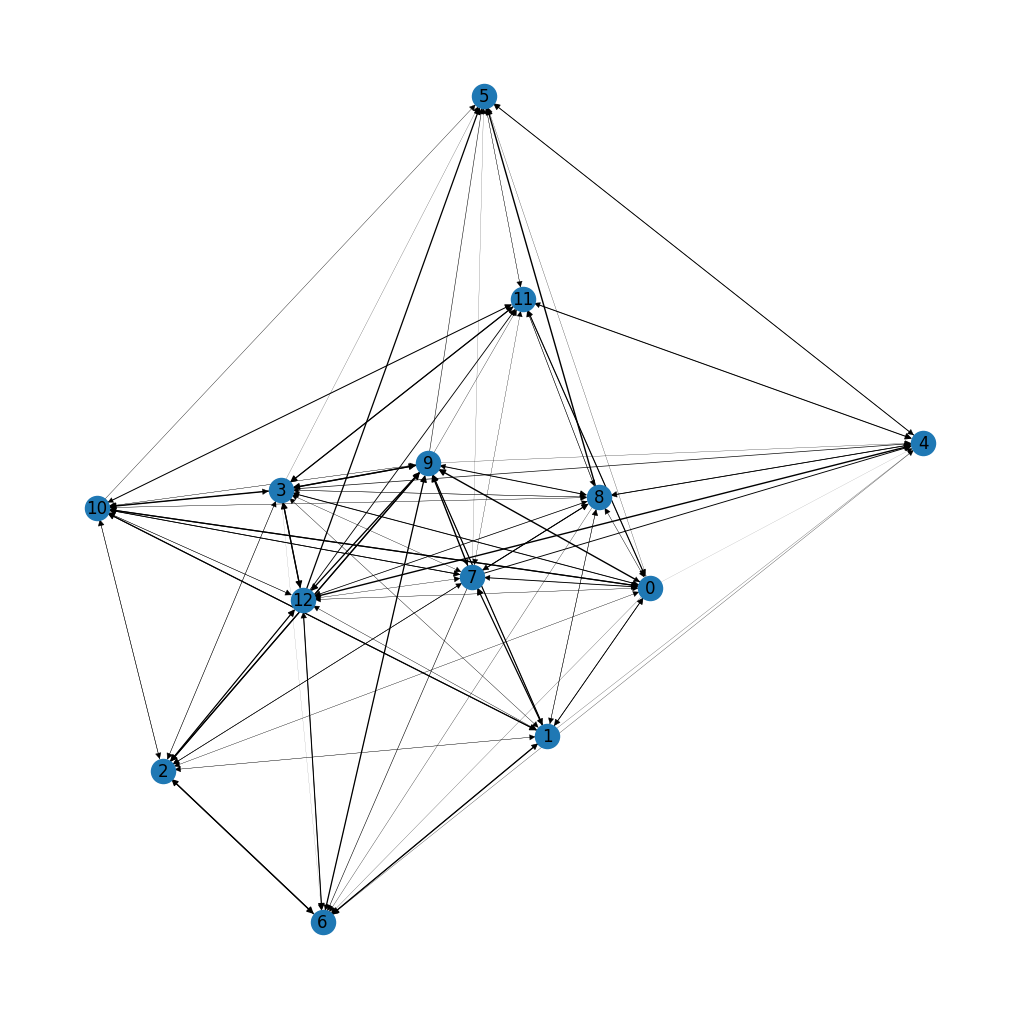

In [12]:
explainer = Explainer(
    model=model,
    algorithm=AttentionExplainer(),
    explanation_type='model',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

explainer_explain("Attention", explainer, model)

In [ ]:
"""
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

explainer_explain("GNN", explainer, model)
"""

'\nexplainer = Explainer(\n    model=model,\n    algorithm=GNNExplainer(),\n    explanation_type=\'model\',\n    node_mask_type=\'attributes\',\n    edge_mask_type=\'object\',\n    model_config=dict(\n        mode=\'regression\',\n        task_level=\'node\',\n        return_type=\'raw\',\n    ),\n)\n\nexplainer_explain("GNN", explainer, model)\n'

In [ ]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
explainer.algorithm = explainer.algorithm.to(device)

duration, x, _, _, border, params = data_test.get(0, duration=-1)

xshape = x.shape

params = params.to(device)
x = x.to(device)

i = 50
    
end = i + 2
start = end - 1

_, edge_index, edge_attr = data_test.get_edges(x[start:end,:,:2].cpu(), data_test.max_degree, wrap=data_test.wrap, T=1, N=x.shape[1], masks=None)

edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)

# Generate the explanation for a particular graph:
explanation = explainer(x=x[start:end][0], edge_index=edge_index, edge_attr=edge_attr, params=params)
      
assert(explanation.validate() == True)

explanation.visualize_feature_importance(path="node_explanation_" + str(start) + name_complete + ".png", feat_labels=["x", "y", "dx", "dy", "degree"])


ValueError: not enough values to unpack (expected 6, got 5)